In [2]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using DSP
# using BenchmarkTools
using Optim

In [3]:
include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

# Load Data:

In [4]:
conv_mat = load("../data/experiment/dataset_2/m2/conv_matrix.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_3"],
);


# Likelihood Function:

In [5]:
param = (
        tr_size = [0.15, 0.15],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [35,35,20,35], # alignment X
        μ_y = [35,35,20,35], # alignment Y
        σ_x = [0,0,0,0], # resolution X
        σ_y = [0,0,0,0], # resolution Y
        δ_x = [0.0271,0.0216,0.114,3*0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,3*0.0298], # pixel size Y
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );


In [68]:

# Data Set 1: 34896.560, 50315.113, 10317.860, 310986.998
# Data Set 2: 35147.44, 50235.06, 10096.64, 33406.9

event = generate_event(param, 25.0, conv_matrices)

(cam_1 = [62 0 … 5 3; 0 14 … 2 1; … ; 1 3 … 4 5; 2 1 … 0 11], cam_2 = [0 1 … 0 0; 17 0 … 107 253; … ; 15 0 … 2 17; 0 3 … 0 3], cam_3 = [146 26 … 370 34; 200 1 … 528 1; … ; 69 1 … 1 23; 8 29 … 1 187], cam_4 = [17 4 … 105 49; 7 30 … 8 1; … ; 70 2 … 0 9; 13 6 … 8 1], population = 25.0)

In [80]:
# Generate 5 simulated Events: 

sim_events = [generate_event(param, 25.0, conv_matrices) for i in 1:5]

# FileIO.save("../data/experiment/dataset_2/m2/simulated_events.jld2", 
#     Dict("array" => sim_events))

In [8]:
images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 1

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)


(cam_1 = [0 0 … 1 2; 0 0 … 0 0; … ; 18 79 … 161 73; 244 0 … 42 0], cam_2 = [1 0 … 0 0; 0 0 … 0 0; … ; 0 336 … 0 0; 98 247 … 0 0], cam_3 = [16 10 … 9 10; 0 43 … 0 24; … ; 10 22 … 5 2; 0 80 … 0 0], cam_4 = [21 14 … 28 22; 18 20 … 29 17; … ; 14 19 … 22 17; 15 13 … 20 14], population = 26.864200592041016)

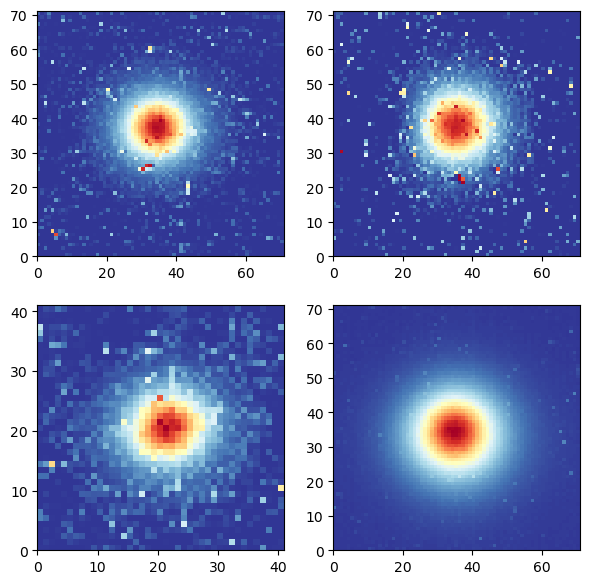

PyObject <matplotlib.collections.QuadMesh object at 0x7fa38b4dcfd0>

In [9]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event[1], cmap="RdYlBu_r")
ax[1,2].pcolormesh(event[2], cmap="RdYlBu_r")
ax[2,1].pcolormesh(event[3], cmap="RdYlBu_r")
ax[2,2].pcolormesh(event[4], cmap="RdYlBu_r")

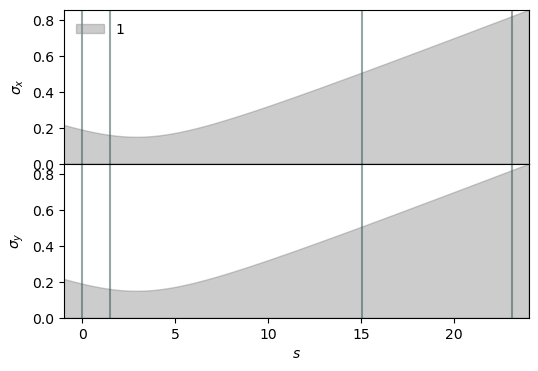

PyObject Text(0.5, 24.0, '$s$')

In [70]:
plot_envelop_trajectory([param,])

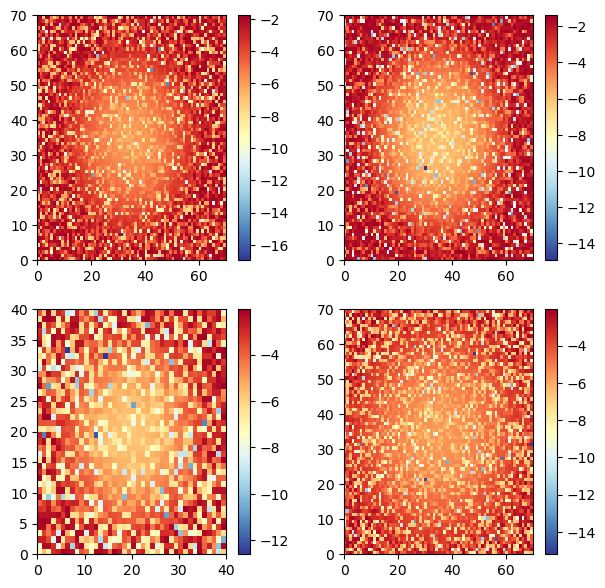

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff70cf0fc70>

In [71]:
log_lik_1 = cam_likelihood_debug(param, event[1], event.population, conv_matrices.cam_1, 1);
log_lik_2 = cam_likelihood_debug(param, event[2], event.population, conv_matrices.cam_2, 2);
log_lik_3 = cam_likelihood_debug(param, event[3], event.population, conv_matrices.cam_3, 3);
log_lik_4 = cam_likelihood_debug(param, event[4], event.population, conv_matrices.cam_4, 4);

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# im = ax.pcolormesh(log_lik, cmap="RdYlBu_r")
# cbar = fig.colorbar(im)

fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

im1 = ax[1,1].pcolormesh(log_lik_1, cmap="RdYlBu_r")
cbar = fig.colorbar(im1, ax=ax[1,1])

im2 = ax[1,2].pcolormesh(log_lik_2, cmap="RdYlBu_r")
cbar = fig.colorbar(im2, ax=ax[1,2])

im3 = ax[2,1].pcolormesh(log_lik_3, cmap="RdYlBu_r")
cbar = fig.colorbar(im3, ax=ax[2,1])

im4 = ax[2,2].pcolormesh(log_lik_4, cmap="RdYlBu_r")
cbar = fig.colorbar(im4, ax=ax[2,2])


In [72]:
# @benchmark total_likelihood($param, $toy_event, $conv_matrices)

total_likelihood(param, event, conv_matrices)

-73655.60355131484

# Optimization:

In [73]:
function vect_to_nt(x::AbstractVector)
    return (
        tr_size = [x[1],x[2]],
        ang_spr = [x[3], x[4]],
        s_waist = [x[5],],
        μ_x = [x[6],x[7],x[8],x[9]], 
        μ_y = [x[10],x[11],x[12],x[13]], 
        σ_x = [0,0,0,0], # resolution X
        σ_y = [0,0,0,0], # resolution Y
        δ_x = [0.0271,0.0216,0.114,3*0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,3*0.0298], # pixel size Y
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    )
end

function nt_to_vect(x::N) where {N <: NamedTuple}
    return [
        x.tr_size..., 
        x.ang_spr..., 
        x.s_waist..., 
        x.μ_x..., 
        x.μ_y..., 
    ]
end

function opt_function(x; event=event, cv = conv_matrices)
    nt = vect_to_nt(x)
    return abs.(total_likelihood(nt, event, cv))
end

opt_function (generic function with 1 method)

In [74]:
param_1 = (
        tr_size = [0.15, 0.15],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [35,35,20,35], # alignment X
        μ_y = [35,35,20,35], # alignment Y
        σ_x = [0,0,0,0], # resolution X
        σ_y = [0,0,0,0], # resolution Y
        δ_x = [0.0271,0.0216,0.114,3*0.0303], # pixel size X
        δ_y = [0.0305,0.0234,0.125,3*0.0298], # pixel size Y
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9], # light intensity coefficient
        s_cam = [0.0, 1.478, 15.026, 23.1150], # camera position
    );

x_0 = nt_to_vect(param_1)

opt_output = optimize(opt_function, x_0)

opt_parameters = vect_to_nt(opt_output.minimizer);

In [75]:
opt_output.minimizer

13-element Array{Float64,1}:
  0.15100799066742432
  0.1512267730912807
  4.036602338734161
  4.051281170371752
  2.886992580887828
 34.978882449580496
 35.012712204777905
 20.037162150428358
 34.96278130085373
 34.985138484162476
 35.017859314123484
 20.008005012610734
 34.964472407615425

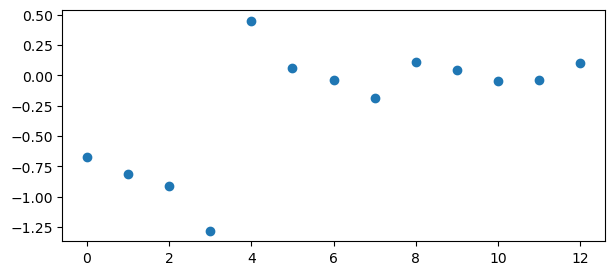

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff70c0fbe80>

In [76]:
per_div = 100 .* (x_0 .- opt_output.minimizer) ./ x_0

fig, ax = plt.subplots(1,1, figsize=(7,3))

ax.plot(per_div, "o")

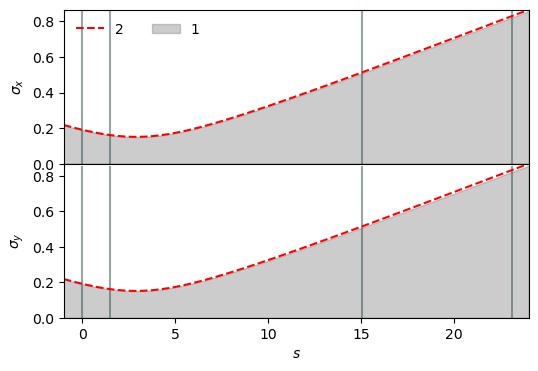

PyObject Text(0.5, 24.0, '$s$')

In [77]:
plot_vector = [param, opt_parameters,]

plot_envelop_trajectory(plot_vector)

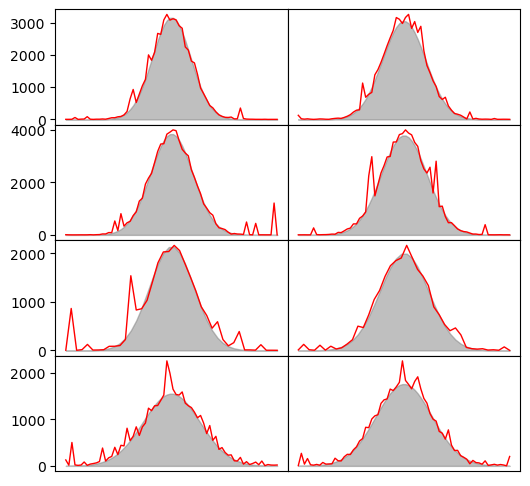

In [78]:
plot_cam_crossections([opt_parameters,], event, conv_matrices)


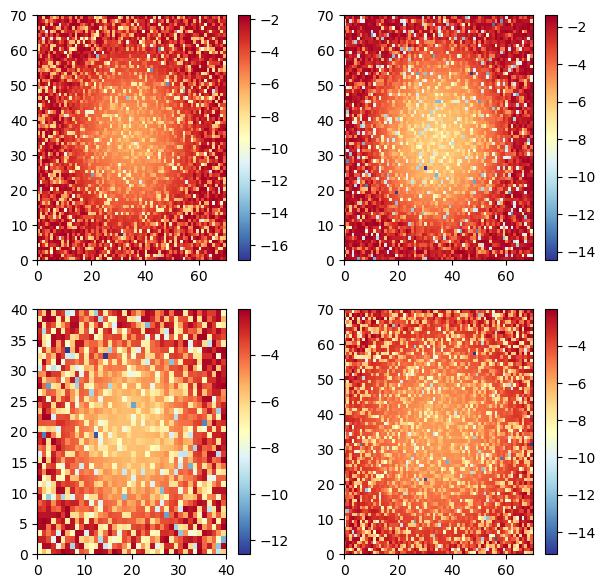

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff710c54c10>

In [79]:
log_lik_1 = cam_likelihood_debug(opt_parameters, event[1], event.population, conv_matrices.cam_1, 1);
log_lik_2 = cam_likelihood_debug(opt_parameters, event[2], event.population, conv_matrices.cam_2, 2);
log_lik_3 = cam_likelihood_debug(opt_parameters, event[3], event.population, conv_matrices.cam_3, 3);
log_lik_4 = cam_likelihood_debug(opt_parameters, event[4], event.population, conv_matrices.cam_4, 4);

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# im = ax.pcolormesh(log_lik, cmap="RdYlBu_r")
# cbar = fig.colorbar(im)

fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

im1 = ax[1,1].pcolormesh(log_lik_1, cmap="RdYlBu_r")
cbar = fig.colorbar(im1, ax=ax[1,1])

im2 = ax[1,2].pcolormesh(log_lik_2, cmap="RdYlBu_r")
cbar = fig.colorbar(im2, ax=ax[1,2])

im3 = ax[2,1].pcolormesh(log_lik_3, cmap="RdYlBu_r")
cbar = fig.colorbar(im3, ax=ax[2,1])

im4 = ax[2,2].pcolormesh(log_lik_4, cmap="RdYlBu_r")
cbar = fig.colorbar(im4, ax=ax[2,2])
